## HW3: Decision Tree, Random Forest, and Adaboost
In hw3, you need to implement decision tree, random forest and adaboost by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

In [1]:
!pip install sklearn

## Load data

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
import random


In [3]:
data = load_breast_cancer()
feature_names = data['feature_names']
print(feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [4]:
x_train = pd.read_csv("x_train.csv").values
y_train = pd.read_csv("y_train.csv").values
x_test = pd.read_csv("x_test.csv").values
y_test = pd.read_csv("y_test.csv").values

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from the course sludes on E3

In [5]:
import math

def gini(sequence):
    impurity = 1
    len_ = len(sequence)
    unique, counts = np.unique(sequence, return_counts=True)
    for i in range(len(unique)):
        probability = (counts[i] / len_)**2
        impurity = impurity - probability
    return impurity

def entropy(sequence):
    answer = 0
    len_ = len(sequence)
    unique, counts = np.unique(sequence, return_counts=True)
    for i in range(len(unique)):
        probability = (counts[i] / len_)
        log_probability = math.log(probability, 2)
        answer = answer + probability * log_probability
    return -1 * answer

In [6]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [7]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [8]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006402


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **Criterion**: The function to measure the quality of a split. Your model should support “gini” for the Gini impurity and “entropy” for the information gain. 
2. **Max_depth**: The maximum depth of the tree. If Max_depth=None, then nodes are expanded until all leaves are pure. Max_depth=1 equals to split data once


In [9]:
class Leaf():
    def __init__(self, data):
        counts = {}
        for row in data :
            label = row[-1]
            if label not in counts:
                counts[label] = 0
            counts[label] = counts[label] + 1
        self.predictions = counts

class Decision_Node():
    def __init__(self, question, left_branch, right_branch, col, feature_importance):
        self.question = question
        self.left_branch = left_branch
        self.right_branch = right_branch
        self.col = col
        self.feature_importance = feature_importance





class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, Plot_tree = False, show_procedure = False):
        self.criterion = criterion
        self.max_depth = max_depth + 1
        self.Plot = Plot_tree
        self.show_procedure = show_procedure
        if criterion == 'gini':
            self.measure_func = gini
        if criterion == 'entropy':
            self.measure_func = entropy
        return None
    
    def partition(self, data, col, question):
        left_data, right_data = [], []
        for index in range(data.shape[0]):
            if data[index, col] <= question :
                left_data.append(data[index])
            else :
                right_data.append(data[index])
        left_data = np.array(left_data)
        right_data = np.array(right_data)
        return left_data, right_data
    
    def info_gain(self, left_data, right_data, current_uncertainty):
        p = float(len(left_data) / (len(left_data) + len(right_data)))
        return current_uncertainty - p * self.measure_func(left_data[:, -1]) - (1-p) * self.measure_func(right_data[:, -1])
    
    def find_best_split(self, data, depth):
        feature = data[:, 0:-1]
        label = data[:, -1]
        best_gain = 0
        best_question = None
        best_col = 0
        best_feature_importance = 0
        current_uncertainty = self.measure_func(label)
        for col in range(feature.shape[1]):
            # Get one columns feature
            values = set([row[col] for row in feature])
            for val in values :
                left_data, right_data = self.partition(data, col, val)
                if (len(left_data) == 0 or len(right_data) == 0):
                    continue
                gain = self.info_gain(left_data, right_data, current_uncertainty)
                feature_importance = gain * len(data)
                if gain > best_gain :
                    best_gain, best_question, best_col = gain, val, col
                    best_feature_importance = feature_importance
                
        return best_gain, best_question, best_col, best_feature_importance
    
    def build_tree(self, data, depth):
        if depth+1 < self.max_depth:
            best_gain, best_question, best_col, best_feature_importance = self.find_best_split(data, depth)
            if self.show_procedure:
                print("====================================================================")
                print(f"Depth is {depth+1}\nThe question is {feature_names[best_col]} <= {best_question}\t Gain is {best_gain:.03f}\t Happend at col {best_col}")
            if best_gain == 0 :
                if self.show_procedure :
                    print(f"Found leaves")
                return Leaf(data)
            else:
                left_data, right_data = self.partition(data, best_col, best_question)
                left_branch = self.build_tree(left_data, depth+1)
                right_branch = self.build_tree(right_data, depth+1)
            return Decision_Node(best_question, left_branch, right_branch, best_col, best_feature_importance)
        else :
            if self.show_procedure:
                print(f"Found leaves")
            return Leaf(data)

    def fit(self, X, y):
        print(f"=============================Start training=============================")
        print(f"Training example shape {X.shape}")
        print(f"Training lable shape {y.shape}")
        data = np.concatenate((X, y), axis = 1)
        depth = 0
        tree = self.build_tree(data, depth)
        if self.Plot:
            print("===============================================")
            self.print_tree(tree)
        return tree
    
    def print_tree(self, node, spacing =""):
        # Base case: we've reached a leaf
        if isinstance(node, Leaf):
            print (spacing + "Predict", node.predictions)
            return
        # Print the question at this node
        print (spacing + feature_names[node.col] +"<=" +str(node.question))

        # Call this function recursively on the true branch
        print (spacing + '--> Left:')
        self.print_tree(node.left_branch, spacing + "  ")

        # Call this function recursively on the false branch
        print (spacing + '--> Right:')
        self.print_tree(node.right_branch, spacing + "  ")
    
    def classify(self, data, node):
        if isinstance(node, Leaf):
            return node.predictions
        else :
            col = node.col
            question = node.question
            if (data[col] <= question):
                return self.classify(data, node.left_branch)
            else :
                return self.classify(data, node.right_branch)

    def print_leaf(self, counts):
        total = float(sum(counts.values()))
        probs = {}
        for class_ in counts.keys():
            probs[class_] = round(float(counts[class_] / total), 3)
        return probs
    
    def count_acc(self, testing_feature, testing_label, node, show_every = False):
        count = 0
        for i in range(len(testing_feature)):
            predict = self.print_leaf(self.classify(testing_feature[i], node))
            predict_answer = int(max(predict, key=predict.get))
            if(predict_answer == testing_label[i]):
                count = count + 1
            if show_every :
                print(f"Ground truth is {y_test[i,0]}\t Predict is {predict}")
        return round(count/testing_feature.shape[0],3)
    
    def Get_feature_importance(self, node):
        dictonary = {}
        self.Calculate_feature_importance(node, dictonary)
        sum_ = sum(dictonary.values())
        dictonary = {k: v / sum_ for k, v in dictonary.items()}
        return dictonary
        
    def Calculate_feature_importance(self, node, dictonary) :
        if isinstance(node, Leaf):
            return
        if feature_names[node.col] not in dictonary:
            dictonary[feature_names[node.col]] = 0
        dictonary[feature_names[node.col]] += node.feature_importance
        self.Calculate_feature_importance(node.left_branch, dictonary)
        self.Calculate_feature_importance(node.right_branch, dictonary)


### Question 2.1
Using Criterion=‘gini’, showing the accuracy score of test data by Max_depth=3 and Max_depth=10, respectively.


In [10]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3, Plot_tree = False, show_procedure = False)
tree = clf_depth3.fit(x_train,y_train)
acc_clf_depth3 = clf_depth3.count_acc(x_test, y_test, tree, show_every = False)
clf_depth3_FI = clf_depth3.Get_feature_importance(tree)


clf_depth10 = DecisionTree(criterion='gini', max_depth=10, Plot_tree = False, show_procedure = False)
tree = clf_depth10.fit(x_train,y_train)
acc_clf_depth10 = clf_depth10.count_acc(x_test, y_test, tree, show_every = False)
clf_depth10_FI = clf_depth10.Get_feature_importance(tree)

print(f"clf_depth3 accuracy is {acc_clf_depth3}")
print(f"clf_depth10 accuracy is {acc_clf_depth10}")

=============================Start training=============================
Training example shape (426, 30)
Training lable shape (426, 1)
=============================Start training=============================
Training example shape (426, 30)
Training lable shape (426, 1)
clf_depth3 accuracy is 0.937
clf_depth10 accuracy is 0.93


### Question 2.2
Using Max_depth=3, showing the accuracy score of test data by Criterion=‘gini’ and Criterion=’entropy’, respectively.


In [11]:
clf_gini = DecisionTree(criterion='gini', max_depth=3, Plot_tree = False, show_procedure = False)
tree = clf_gini.fit(x_train,y_train)
acc_gini = clf_gini.count_acc(x_test, y_test, tree, show_every = False)
clf_gini_FI = clf_gini.Get_feature_importance(tree)

clf_entropy = DecisionTree(criterion='entropy', max_depth=3, Plot_tree = False, show_procedure = False)
tree = clf_entropy.fit(x_train,y_train)
acc_entropy = clf_entropy.count_acc(x_test, y_test, tree, show_every = False)
clf_entropy_FI = clf_entropy.Get_feature_importance(tree)
print(f"clf_gini accuracy is {acc_gini}")
print(f"clf_entropy accuracy is {acc_entropy}")

=============================Start training=============================
Training example shape (426, 30)
Training lable shape (426, 1)
=============================Start training=============================
Training example shape (426, 30)
Training lable shape (426, 1)
clf_gini accuracy is 0.937
clf_entropy accuracy is 0.951


- Note: All of your accuracy scores should over 0.9
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the feature counts for building tree without normalize the importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

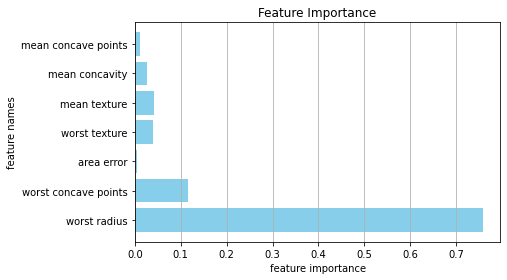

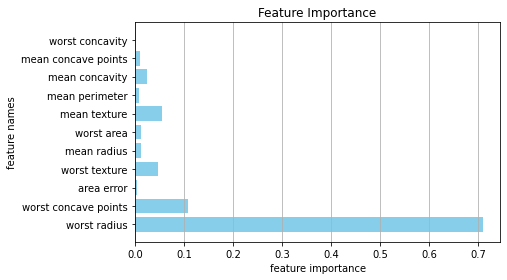

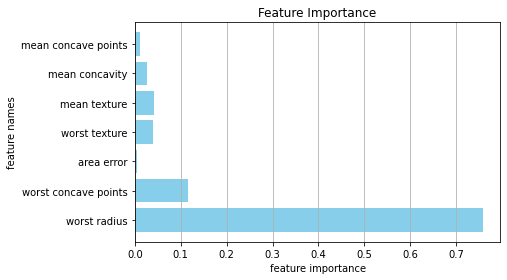

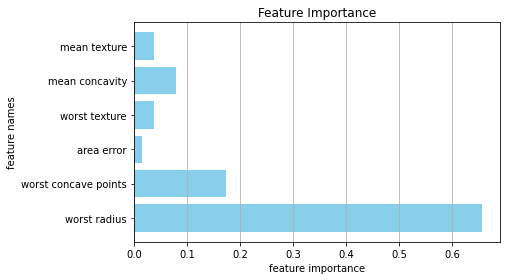

In [18]:
import matplotlib.pyplot as plt

def show_Feature_Importance(feature_importance):
    plt.clf()
    plt.title("Feature Importance")
    plt.xlabel('feature importance')
    plt.ylabel('feature names')
    plt.gca().grid(axis = 'x', which = 'major')
    plt.tight_layout()
    FI = feature_importance.items()
    x, y = zip(*FI)
    plt.barh(x, y, color = 'skyblue')
    plt.show()

show_Feature_Importance(clf_depth3_FI)
show_Feature_Importance(clf_depth10_FI)
show_Feature_Importance(clf_gini_FI)
show_Feature_Importance(clf_entropy_FI)

## Question 4
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **N_estimators**: The number of trees in the forest. 
2. **Max_features**: The number of random select features to consider when looking for the best split
3. **Bootstrap**: Whether bootstrap samples are used when building tree


In [19]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None, Plot_tree = False, show_procedure = False):
        self.n_estimators = n_estimators
        self.max_features = int(max_features)
        self.boostrap = boostrap
        self.max_depth = max_depth
        if max_depth == None:
            self.max_depth = 1000
        self.Plot_tree = Plot_tree
        self.show_procedure = show_procedure
        self.criterion = criterion
        if criterion == 'gini':
            self.measure_func = gini
        if criterion == 'entropy':
            self.measure_func = entropy
            
        self.top_decision = []    
        self.forest = []
        for i in range(self.n_estimators):
            self.forest.append(DecisionTree(criterion=self.criterion, max_depth=self.max_depth, Plot_tree=self.Plot_tree, show_procedure = self.show_procedure))
        
        self.random_choose = []
        
    def fit(self, x, y):
        number , feature_num = x.shape
        feature_all = np.arange(feature_num)
        number_all = np.arange(number)
        for i in range(self.n_estimators):
            print(f"-------------------------------------Processing forest {i}-------------------------------------")
            random_feature = random.sample(list(feature_all), self.max_features)
            self.random_choose.append(random_feature)
            if self.boostrap:
                sample_number = random.sample(list(number_all), int(number * 2/3))
                self.top_decision.append(self.forest[i].fit(x[sample_number][:,random_feature], y[sample_number]))
            else:
                self.top_decision.append(self.forest[i].fit(x[:,random_feature], y))
        return self.top_decision
    
    def count_acc(self, x, y):
        pred = np.zeros((len(y),1))
        count = 0
        for i in range(len(x)):
            vote= []
            for j in range(self.n_estimators):
                Now_tree = self.forest[j]
                Now_top_decision = self.top_decision[j]
                Now_choose = self.random_choose[j]
                predict = Now_tree.print_leaf(Now_tree.classify(x[i, Now_choose], Now_top_decision))
                predict_answer = int(max(predict, key = predict.get))
                vote.append(predict_answer)
            predict , count_ = np.unique(np.array(vote), return_counts=True)
            pred[i] = predict[np.argmax(count_)]
            if pred[i] == y[i] :
                count += 1
        return round(count/len(y),3)

        


### Question 4.1
Using Criterion=‘gini’, Max_depth=None, Max_features=sqrt(n_features), showing the accuracy score of test data by n_estimators=10 and n_estimators=100, respectively.


In [20]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]), boostrap=True, criterion='gini', max_depth=None, Plot_tree = False, show_procedure = False)
clf_10tree_forest = clf_10tree.fit(x_train, y_train)
clf_10tree_acc = clf_10tree.count_acc(x_test, y_test)

clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]), boostrap=True, criterion='gini', max_depth=None, Plot_tree = False, show_procedure = False)
clf_100tree_forest = clf_100tree.fit(x_train, y_train)
clf_100tree_acc = clf_100tree.count_acc(x_test, y_test)


-------------------------------------Processing forest 0-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 1-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 2-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 3-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 4----------------------------

-------------------------------------Processing forest 26-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 27-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 28-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 29-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 30-----------------------

-------------------------------------Processing forest 62-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 63-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 64-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 65-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 66-----------------------

-------------------------------------Processing forest 98-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 99-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)


In [21]:
print(f"The accuracy of n_estimators=10 is {clf_10tree_acc}")
print(f"The accuracy of n_estimators=100 is {clf_100tree_acc}")

The accuracy of n_estimators=10 is 0.944
The accuracy of n_estimators=100 is 0.93


### Question 4.2
Using Criterion=‘gini’, Max_depth=None, N_estimators=10, showing the accuracy score of test data by Max_features=sqrt(n_features) and Max_features=n_features, respectively.


In [16]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]), boostrap=True, criterion='gini', max_depth=None, Plot_tree = False, show_procedure = False)
clf_random_features_forest = clf_random_features.fit(x_train, y_train)
clf_random_features_acc = clf_random_features.count_acc(x_test, y_test)
                                   
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1], boostrap=True, criterion='gini', max_depth=None, Plot_tree = False, show_procedure = False)
clf_all_features_forest = clf_all_features.fit(x_train, y_train)
clf_all_features_acc = clf_all_features.count_acc(x_test, y_test)
    

-------------------------------------Processing forest 0-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 1-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 2-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 3-------------------------------------
=============================Start training=============================
Training example shape (284, 5)
Training lable shape (284, 1)
-------------------------------------Processing forest 4----------------------------

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [17]:
print(f"The accuracy of random_feature is {clf_random_features_acc}")
print(f"The accuracy of all_feature is {clf_all_features_acc}")

The accuracy of random_feature is 0.916
The accuracy of all_feature is 0.93


## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 